# Music Genre Analysis
#### Music Genre Classification and Clustering Using Keyword-Based Embeddings and PCA
This project focuses on analyzing and clustering songs based on their descriptive keywords, which represent the instrument, mood, and style of each song. Using techniques like TF-IDF vectorization, Principal Component Analysis (PCA) for dimensionality reduction, and K-means clustering, the goal is to group similar songs together and explore how well these clusters align with their true genres. 
The only libraries used were numpy, pandas, and matplotlib. No use of prebuilt functions from sklearn is present.
## The Dataset
The dataset contains songs described by three keywords (which mainly give insights about the
instrument used, the mood of the song, and the style of the song), and each song has been
labeled with its corresponding genre as a ground truth. There are 147 songs in total. There were seemingly no missing values in the dataset. Hence not much data cleaning was required.

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#sklearn not allowed 

In [295]:
data = pd.read_csv("dataset.csv")  #147 rows with columns: instrument, mood, style, genre

instruments = data["keyword_1"].tolist()
moods = data["keyword_2"].tolist()
styles = data["keyword_3"].tolist()
genres = data["genre"].tolist()
print(moods[3])
data.head()

energetic


,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


Here we see the distribution of songs amongst various keywords.
There are 6 unique instrument keywords, 9 unique mood keywords, and 10 unique style keywords.
Seeing the distribution of songs amongst these can give an insight into what to expect in the later formed clusters and how well they align with the true genres.

In [296]:
#organising data through genres, showing the count of each  unique item for all 3 keywords
genre_instrument_counts = data.groupby('genre')['keyword_1'].value_counts().unstack(fill_value=0)
genre_mood_counts = data.groupby('genre')['keyword_2'].value_counts().unstack(fill_value=0)
genre_style_counts = data.groupby('genre')['keyword_3'].value_counts().unstack(fill_value=0)

print(genre_instrument_counts)
print(genre_mood_counts)
print(genre_style_counts)

keyword_1  banjo  brass  guitar  piano  synth  violin
genre                                                
classical      0     11       0      6      0      10
country        6      0      23      0      0       0
hip-hop        0      0       0      0     30       0
pop            0      0      12      6     13       0
rock           0      0      30      0      0       0
keyword_2  angry  calm  emotional  energetic  happy  mellow  nostalgic  sad  \
genre                                                                         
classical      0     7          0          5      6       5          0    4   
country        0     0          4          5      6       6          3    5   
hip-hop        6     0          0          6      6       6          0    6   
pop            0     4          7          5      6       5          0    0   
rock           6     0          0          6      6       6          0    6   

keyword_2  upbeat  
genre              
classical       0  
country 

## Vectorisation methods
We will be using two methods for vectorization: Bag of Words and TF-IDF.
Bag of Words is a simple vectorization technique where each keyword is represented as a one-hot encoded vector. This method is simple and easy to implement.
TF-IDF (Term Frequency-Inverse Document Frequency) is a more advanced vectorization technique that gives more weight to less frequent terms. This method is more sophisticated and can give better results than Bag of Words.(not in this case though)

**Note: here a "document" refers to a song and a "term" refers to a keyword.**

### The code
1) The `compute_tfidf` function computes the TF-IDF vector for a given list of keywords. It returns the TF-IDF matrix and the unique terms in the dataset. The IDF values are calculated using the formula: $IDF = \log(\frac{N}{\text{count}})$.The TF values are 1 for all keywords. 
2) The `BoW` function creates a Bag of Words vector for a given keyword. It returns a binary encoded vector based on the unique terms in the dataset.
3) `keyword_binary` and `keyword_tfidf` are the binary and TF-IDF vectors for each keyword category (instrument, mood, style) after applying the respective vectorization techniques. The shapes of these vectors are (147, 6), (147, 9), and (147, 10) respectively. They are numpy arrays.
4) The `instrument_terms`, `mood_terms`, and `style_terms` are the unique terms in the dataset for each keyword category.

In [297]:
#tfidf vectorization
def compute_tfidf(keywords):
    unique_terms, term_counts = np.unique(keywords, return_counts=True)
    N = len(keywords)
    idf = {term: np.log(N / count) for term, count in zip(unique_terms, term_counts)}
    
    vocab_size = len(unique_terms)
    tfidf_matrix = np.zeros((N, vocab_size))
    term_to_idx = {term: i for i, term in enumerate(unique_terms)}
    
    for i, term in enumerate(keywords):
        tfidf_matrix[i, term_to_idx[term]] = idf[term]  # TF=1 
    
    return tfidf_matrix
  

In [298]:
# bag of words vectorization
def BoW(keyword, unique_terms): 
    vector = np.zeros(len(unique_terms))
    if keyword in unique_terms:
        vector[unique_terms.index(keyword)] = 1
    return vector

instrument_terms = data["keyword_1"].unique().tolist()
mood_terms = data["keyword_2"].unique().tolist()
style_terms = data["keyword_3"].unique().tolist()

In [299]:
#bow vectors for each category
instrument_binary = np.array([BoW(term, instrument_terms) for term in instruments]) #shape: (147, 6)
mood_binary = np.array([BoW(term, mood_terms) for term in moods]) #shape: (147, 9)
style_binary = np.array([BoW(term, style_terms) for term in styles]) #shape: (147, 10)

# tfidf vectors for each category
instrument_tfidf = compute_tfidf(instruments)  #(147, 6)
mood_tfidf = compute_tfidf(moods)                   # (147, 9)
style_tfidf = compute_tfidf(styles)                # (147, 10)

print(mood_binary[3])

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Dimensionality Reduction using PCA
### Reducing the 3 Dimensional Vectors to 2 Dimensions
The Bag of Words and TF-IDF vectors for each keyword category are 3-dimensional. We will use Principal Component Analysis (PCA) to reduce these vectors to 2 dimensions. This will help in visualizing the songs in a 2D space and clustering them based on these reduced embeddings.
The class has a fit and transform method. The fit method calculates the eigenvectors and eigenvalues of the covariance matrix of the data. The transform method projects the data onto the first n eigenvectors to reduce the dimensionality. 
Thankfully numpy has a built-in function for calculating eigenvectors and eigenvalues, which simplifies our task.

In [300]:
# pca class for dimensionality reduction
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # cov matrix
        cov = np.cov(X.T)  # X.T is the transpose of X
        #cov is a 3x3 matrix giving a measure of the variation between each pair of features(keywords)

        #eigenvectors are the line through the "longest spread" of song data (most variance)
        #eigenvalues quantify the amount of variance in the direction of the eigenvector
        eigenvalues, eigenvectors = np.linalg.eig(cov) #thankfully numpy has a built in function for this
        eigenvectors = eigenvectors.T  
        
        #our axes are the orthogonal eigenvectors of the 2 highest eigenvalues obtained from the covariance matrix
        desc_index = np.argsort(eigenvalues)[::-1]  #obtains indexes in descending order of eigenvalues 
        eigenvalues = eigenvalues[desc_index]
        eigenvectors = eigenvectors[desc_index]
        
        # store the first n (2) eigenvectors
        self.components = eigenvectors[0 : self.n_components] #slice the first 2 eigenvectors
        
    def transform(self, X):
        X = X - self.mean
        # project data onto eigenvectors
        return np.dot(X, self.components.T)

## Combining Embeddings 
### Weighted Combination of Embeddings
We will combine the 2-dimensional embeddings obtained from PCA for each keyword category (instrument, mood, style) using different weights. The combined embedding will be used for clustering the songs. The weights are chosen based on the importance of each keyword category in determining the genre of a song. (These weights are arbitrary and can be changed based on the dataset and requirements. For now they are chosen on the basis of intuition)

### **Note: going forward we will be using the binary vectors for the clustering process because they simply give better and more separable clusters than TF-IDF**

In [301]:
# applying PCA to each column
pca = PCA(2)

pca.fit(instrument_binary)
bin_instrument_pca = pca.transform(instrument_binary) 
pca.fit(mood_binary)  
bin_mood_pca = pca.transform(mood_binary)  
pca.fit(style_binary)
bin_style_pca = pca.transform(style_binary) 
print(bin_mood_pca[3])
# combine embeddings using weights
combined_embedding_binary = (0.75*bin_instrument_pca + 0.15*bin_mood_pca + 0.10*bin_style_pca)   # Shape: (147, 2)

[-0.27745219  0.74898762]


In [302]:
# applying PCA to each category
pca = PCA(2)

pca.fit(instrument_tfidf)
tf_instrument_pca = pca.transform(instrument_tfidf) 
pca.fit(mood_tfidf) 
tf_mood_pca = pca.transform(mood_tfidf) 
pca.fit(style_tfidf) 
tf_style_pca = pca.transform(style_tfidf)  

# combine embeddings using weights
combined_embedding_tfidf = (0.75*tf_instrument_pca + 0.15*tf_mood_pca + 0.10*tf_style_pca)   #(147, 2)

#### Below is a plot of all the songs color-coded by their genres. It already shows three distinct clusters, which goes against the actual number of unique genres (6). This suggests that the songs are not well-separated based on their genres.

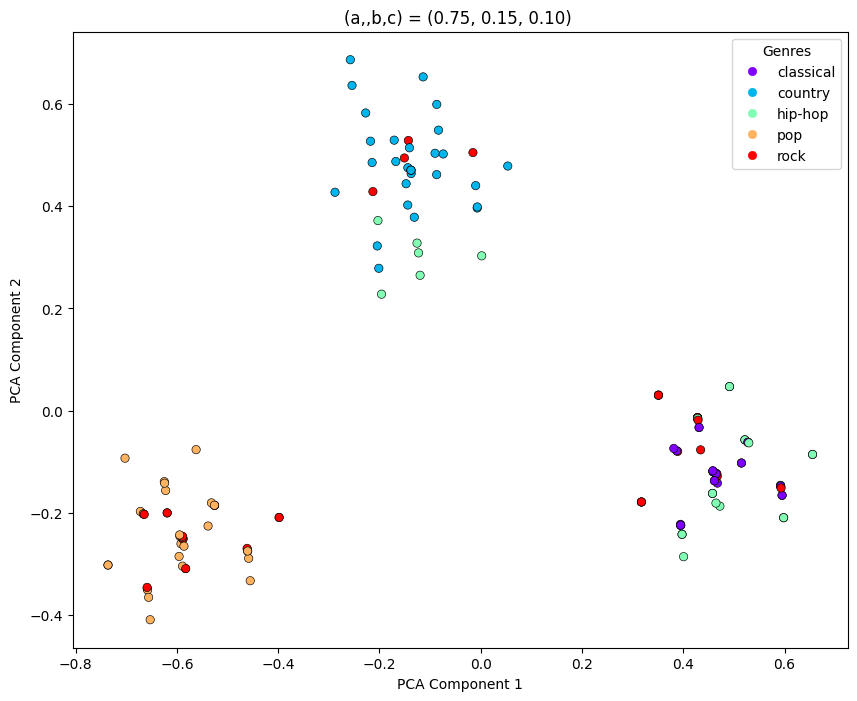

In [303]:
# plotting the 2d embeddings obtained from PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(combined_embedding_binary[:, 0], 
                      combined_embedding_binary[:, 1], 
                      c=pd.factorize(pd.Series(genres))[0],
                      cmap='rainbow',
                      edgecolors='black', linewidths=0.45)

plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(genres).tolist(), title="Genres")

plt.title("(a,,b,c) = (0.75, 0.15, 0.10) ")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## K-means Clustering
### The KMeans class
The KMeans class has the following methods:
1) `__init__`: Initializes the KMeans object with the number of clusters (k) and the maximum number of iterations.
2) `fit`: Fits the KMeans model to the data and returns the cluster labels for each data point.
The KMeans algorithm consists of the following steps:
1) Randomly initialize k centroids. (k can be determined using the elbow curve method)
2) Assign each data point to the nearest centroid.
3) Once all data points are assigned a cluster, update the centroids to be the mean of the data points in each cluster.
4) Repeat steps 2 and 3 until convergence (centroids don't change much/at all) or until the maximum number of iterations is reached.
5) Once the above loop ends, return the cluster labels for each data point.

We now have a `labels` array containing the index of the cluster each song belongs to. 

In [304]:
class KMeans:
    def __init__(self, k, max_iters=500):
        self.k = k                # number of clusters
        self.max_iters = max_iters  #iterations to run (if no convergence)
        self.centroids = None     #cluster centers

    def fit(self, X):
        #(147,2)
        n_samples, n_features = X.shape

        ### 1) randomly init centroids by picking k unique points from X
        np.random.seed(42)  # fix the seed for reproducibility
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for iter in range(self.max_iters):
            ### 2) assignment step: assign each point to its nearest centroid
            #array to store the nearest cluster label for each data point
            labels = np.zeros(n_samples, dtype=int)

            for i in range(n_samples):
                #get the euclidean dist from the point X[i] to each centroid
                distances = []
                for centroid in self.centroids:
                    distance = np.sqrt(np.sum((X[i] - centroid) ** 2)) ##all hail np
                    distances.append(distance)
                #assign the point to the cluster center with the smallest dist from it
                labels[i] = np.argmin(distances) #argmin returns the index of the smallest distance

            ### 3)update step: get new centroids as the mean of the points in each cluster
            new_centroids = np.zeros_like(self.centroids)
            for j in range(self.k):
                # get all points that were assigned to cluster j
                cluster_points = X[labels == j]
                if len(cluster_points) > 0:
                    # mean of points in the cluster becomes the new centroid
                    new_centroids[j] = np.mean(cluster_points, axis=0)
                else:
                    # if a cluster gets no points, randomly reinitialize its centroid.(all hail andrew ng)
                    new_centroids[j] = X[np.random.choice(n_samples)]

            ### 4)check for convergence: if centroids havent changed, exit loop
            if np.allclose(self.centroids, new_centroids, atol=1e-6):
                break

            # update the centroids for the next iteration(we have not converged yet)
            self.centroids = new_centroids

        # return final labels for each data point
        return labels

### The Elbow Method
This method is used to find the optimal value of k for KMeans clustering. The idea is to plot the sum of squared distances of data points to their closest cluster center (inertia) for different values of k. The point where the inertia starts decreasing at a slower rate is considered the optimal value of k(elbow point). This point is called the "elbow point". Like in most ML algorithms, here we are trying to minimise a cost function. 


For us, an ideal value of k, would be one where the clusters are well-separated and distinct, AND where the genres align well with the clusters. i.e a value close to 6 is ideal for us. But from the elbow curve, we can see that the inertia is decreasing at a slower rate after k=3. Hence, we will use k=3 for clustering the songs. It is also clearly visible from the plot of the data points that k=3 gives well-separated clusters.

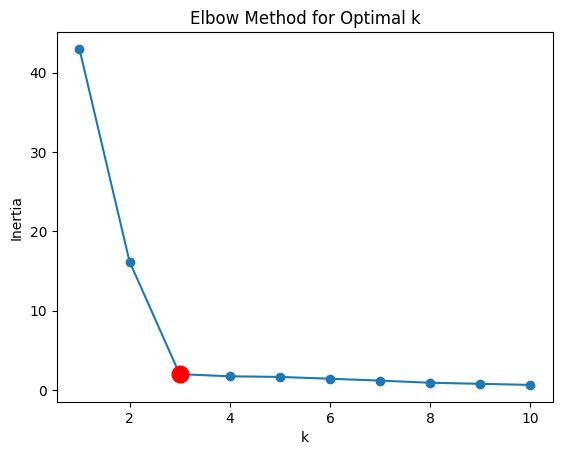

In [305]:
#elbow method for best k
costs = [] ##inertia is the sum of squared dist of each data point to their closest cluster center
#it is an optimisation metric for kmeans. idhar cost basically inertia ko hi keh rahe hain
for k in range(1, 11):
    kmeans = KMeans(k=k)
    labels = kmeans.fit(combined_embedding_binary)
    cost = np.sum([np.sum((combined_embedding_binary[labels == i] - kmeans.centroids[i])**2) for i in range(k)])
    costs.append(cost)

# elbow curve plot
plt.plot(range(1, 11), costs, marker='o')
plt.plot(3, costs[2], marker='o', markersize=12, label='k=3', c='red')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

##on some runs there is a jump on random values of k, dk why(poor initialisation maybe). try random seed

Plot of the data points and their respective clusters after applying KMeans clustering with k=3. The clusters are well-separated and distinct, which is a good sign that the clustering algorithm is working well. 

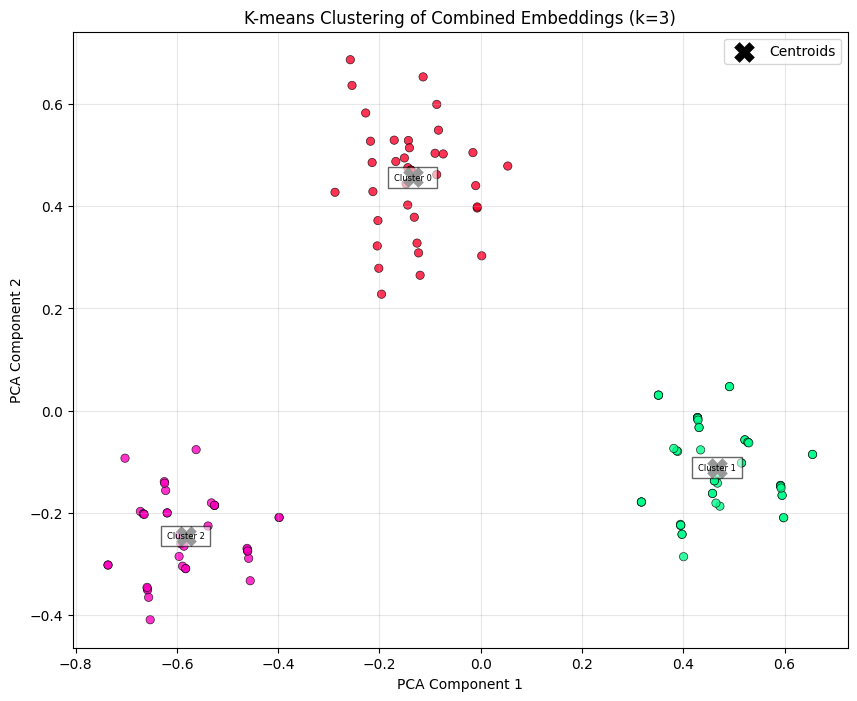

In [306]:
# fit with optimal k (k=3 or 4 in this case)
kmeans = KMeans(k=3)
labels = kmeans.fit(combined_embedding_binary)
cluster_names = [f"Cluster {i}" for i in range(kmeans.k)]
# cluster plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(combined_embedding_binary[:, 0], combined_embedding_binary[:, 1], c=labels, cmap='gist_rainbow', alpha=0.8, edgecolors='black', linewidths=0.5)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='black', marker='X', s=200, label='Centroids', edgecolors='black', linewidths=0.5)
for i, (x, y) in enumerate(kmeans.centroids):
    plt.text(x, y, cluster_names[i], fontsize=6, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.6))

plt.title("K-means Clustering of Combined Embeddings (k=3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Evaluation Metric: Silhouette Score
The silhouette score is a measure of how similar an object is to its own cluster  compared to other clusters (separation). The silhouette score ranges from -1 to 1. A score close to 1 indicates that the data point is well-clustered, while a score close to -1 indicates that the data point is misclustered. A score around 0 indicates that the data point is on the border of two clusters.

Formula for silhouette score: $\frac{b - a}{\max(a, b)}$, where $a$ is the average distance between a sample and all other points in the same cluster, and $b$ is the average distance between a sample and all other points in the nearest cluster.

In [307]:
def silhouette_score(data, labels): 
    n = len(data)
    a = np.zeros(n)  # same-cluster avg distance
    b = np.zeros(n)  #nearest-other cluster distance
    
    for i in range(n):
        cluster = labels[i]
        same_cluster = data[labels == cluster]
        a[i] = np.mean(np.linalg.norm(same_cluster - data[i], axis=1))
        
        # distance to nearest other cluster
        other_clusters = [c for c in np.unique(labels) if c != cluster]
        distances = []
        for c in other_clusters:
            other_cluster_data = data[labels == c]
            distances.append(np.mean(np.linalg.norm(other_cluster_data - data[i], axis=1)))
        b[i] = np.min(distances)
    
    score = np.mean((b - a) / np.maximum(a, b)) #silhouette score formula
    return score

Upon calculating the silhouette score for the clustering of songs, we get a score of 0.93 which is close to 1. This indicates that the songs are well-clustered and the clustering algorithm is working well.

But this method of evaluation is not perfect. It is a good metric for evaluating the quality of clusters but it does not take into account the true ground truth genres of the songs. Hence, we will also look at how well the clusters align with the true genres of the songs.

In [311]:
ss = silhouette_score(combined_embedding_binary, labels)
print(f"Silhouette Score: {ss:.4f}")

Silhouette Score: 0.8250


## Assigning Genres to New Songs
We will now assign genres to new songs based on their descriptive keywords. The keywords are vectorized using Bag of Words, and the embeddings are combined using the same weights as before. The predicted cluster for each new song is obtained by finding the nearest centroid to its embedding. The predicted clusters are then mapped to the true genres to assign a genre to each new song.

In [309]:
##assigning genre to new songs
new_songs = [
    ["piano", "calm", "slow"],
    ["guitar", "emotional", "distorted"],
    ["synth", "mellow", "distorted"]
]
new_embeddings = []
for song in new_songs:
    #vectors for each keyword
    instrument_vector = BoW(song[0], instrument_terms)  
    mood_vector = BoW(song[1], mood_terms)
    style_vector = BoW(song[2], style_terms)
    
    pca.fit(instrument_binary)
    instrument_emb = pca.transform(np.array([instrument_vector]))  #  (1,2)
    pca.fit(mood_binary)
    mood_emb = pca.transform(np.array([mood_vector]))  #  (1,2)
    pca.fit(style_binary)
    style_emb = pca.transform(np.array([style_vector]))  #  (1,2)
    
    # combine embeddings (same weights as before)
    combined_emb = 0.9 * instrument_emb + 0.05 * mood_emb + 0.05 * style_emb
    new_embeddings.append(combined_emb[0])

new_embeddings = np.array(new_embeddings)

def predict_cluster(new_embedding, centroids):
    #euclidean distances from the new point to each centroid
    distances = np.sqrt(np.sum((centroids - new_embedding)**2, axis=1))
    return np.argmin(distances)
predicted_clusters = [predict_cluster(emb, kmeans.centroids) for emb in new_embeddings]

newsong_df = pd.DataFrame({
    "Keywords": [", ".join(song) for song in new_songs],
    "Embedding": [f"({emb[0]:.2f}, {emb[1]:.2f})" for emb in new_embeddings],
    "Predicted Cluster": predicted_clusters
})

print(newsong_df.to_string(index=False))

                    Keywords      Embedding  Predicted Cluster
           piano, calm, slow  (-0.17, 0.61)                  0
guitar, emotional, distorted  (0.56, -0.15)                  1
    synth, mellow, distorted (-0.73, -0.33)                  2


## Cluster-Genre Purity Table
The above results from predicting the cluster of new songs can be evaluated using a **cluster-genre purity table**. This table shows the percentage of songs in each cluster that belong to each genre.

This table can be used to judge which genre the new song is most likely to belong to based on the cluster it is assigned to.

This extrinsic metric of evaluation takes into account the ground truth genres of the songs and how well they align with the clusters formed by the KMeans algorithm.

In [314]:
# cluster-genre alignment table
cluster_genres = {i: {} for i in range(kmeans.k)} #initialise a dictionary with keys as cluster labels
#populate 
for label, genre in zip(labels, genres):  
    if genre in cluster_genres[label]:
        cluster_genres[label][genre] += 1
    else:
        cluster_genres[label][genre] = 1
cluster_genre_df = pd.DataFrame.from_dict(cluster_genres, orient='index')
cluster_genre_df = cluster_genre_df.fillna(0)
cluster_genre_df_percentage = cluster_genre_df.div(cluster_genre_df.sum(axis=1), axis=0) * 100
print(cluster_genre_df_percentage)

   classical    country        pop       rock    hip-hop
0  69.230769  15.384615  15.384615   0.000000   0.000000
1   0.000000  35.384615  18.461538  46.153846   0.000000
2   0.000000   0.000000  30.232558   0.000000  69.767442


# Conclusion
This project demonstrated how keyword-based analysis can effectively group and classify songs into meaningful clusters that align with their true genres. By leveraging TF-IDF vectorization, PCA for dimensionality reduction, and K-means clustering, we transformed textual keywords into actionable insights about music genres.